# SCSS-Net: Solar Corona Structures Segmentation by Deep Learning


---


#          Part II: Segmentation of Active Regions


---


## Authors
**Š. Mackovjak $^1$, M. Harman * $^2$, V. Maslej-Krešňáková $^2$, P. Butka $^2$**


$^1$   Department of Space Physics, Institute of Experimental Physics, Slovak Academy of Sciences, Košice, Slovakia

$^2$  Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia

  \* main author of the code (for more details refer to [personal repo](https://github.com/matinus99/sun-segmentation))

## Contact
All questions and comments related to this work can be addresed to:
Simon Mackovjak, Institute of Experimental Physics, Slovak Academy of Sciences, Watsonova 47, 04001 Košice, Slovakia, mackovjak(at)saske.sk


## Abstract
Structures in the solar corona are the main drivers of space weather processes that might directly or indirectly affect the Earth. Thanks to the most recent space-based solar observatories, with capabilities to acquire high-resolution images continuously, the structures in the solar corona can be monitored over the years with a time resolution of minutes. For this purpose, we have developed a method for automatic segmentation of solar corona structures observed in EUV spectrum that is based on a deep learning approach utilizing Convolutional Neural Networks. The available input datasets have been examined together with our own dataset based on the manual annotation of the target structures. Indeed, the input dataset is the main limitation of the developed model's performance. Our SCSS-Net model provides results for coronal holes and active regions that could be compared with other generally used methods for automatic segmentation. Even more, it provides a universal procedure to identify structures in the solar corona with the help of the transfer learning technique. The outputs of the model can be then used for further statistical studies of connections between solar activity and the influence of space weather on Earth.


---



## Jupyter notebook – Segmentation of Active Regions
In the following, we present the data and Python methods used for analysis described in the article. Here is an overview of the Jupyter notebook:
1. Environment set-up
2. Data preparation
3. Deep learning approach
4. Results of SCSS-net


# 1. Environment set-up

* Clone SCSS-net repo and set-up the environment

In [ ]:
import sys, os
!git clone https://github.com/space-lab-sk/scss-net.git
%cd scss-net
#!git pull origin main                # uncomment and start here if the repo is already cloned
!pip install -r requirements.txt
sys.path.append('../scss-net/src')

* Import libraries

In [2]:
from mega import Mega
import zipfile
import glob
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import albumentations
from ImageDataAugmentor.image_data_augmentor import *

* Import local utilities

In [3]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics

# 2. Data preparation

Solar Dynamic Observatory / Atmospheric Imaging Assembly - SDO / AIA 193 data are used in this work. For more data details refer to [NASA web page](https://sdo.gsfc.nasa.gov). The data were downloaded via [Helioviewer API](https://api.helioviewer.org) for the same date and time as the time stamp of available annotations.  

Annotations used in this notebook are combination of following sources:
* [Custom](https://github.com/space-lab-sk/scss-net/blob/main/src/custom_data_preparation.ipynb) *(this Jupyter notebook also contains steps to preprocess SDO/AIA data and Custom annotations)*
* [SPoCA](https://www.lmsal.com/hek/)

In [4]:
# DOWNLOAD ready-to-use preprocessed and rotated data and annotations for the purpose of this notebook (~530 MB)
mega = Mega()
m = mega.login()
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/1Dg0iaAA#0ZRzdon9F7j0jiCjWHfUh-JNoxw5zfcmzceKrh_VySo')
except PermissionError:
    pass
print("Unzipping ...")
with zipfile.ZipFile("171.zip","r") as zip_ref:
    zip_ref.extractall("data")
print("DONE")

Unzipping ...
DONE


* Create lists with path to each image file and annotation and merge both data sources

In [5]:
imgs_spoca = glob.glob("./data/171_train/171(spoca)/imgs/*.png")
masks_spoca = glob.glob("./data/171_train/171(spoca)/masks/*.png")

imgs_zoon = glob.glob("./data/171_train/171(zooniverse)/imgs/*.png")
masks_zoon = glob.glob("./data/171_train/171(zooniverse)/masks/*.png")

# merge
imgs = imgs_spoca + imgs_zoon
masks = masks_spoca + masks_zoon

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

Imgs number = 6496
Masks number = 6496


* Set global variables

In [6]:
IMG_SIZE = 256     # resize imgs to 256x256
BATCH_SIZE = 20    # Set batch size
SEED = 42          # set seed for reproducibility
EPOCHS = 100       # Set number of epochs

MODEL_NAME = "model_ar_spoca_custom"                   # Specify model name
model_filename = f"./{MODEL_NAME}.h5"                  # Specify path where to save model

* Load, Resize, and Convert data to list of np arrays

In [7]:
imgs_list = []     # list of input images
masks_list = []    # list of annotations

for image, mask in zip(imgs, masks):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

* Normalize, reshape and slpit data

In [8]:
# Normalization from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

# Split data to Train set (90%) and Validation set (10%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=None, shuffle=True)

* Add augumentations to train set

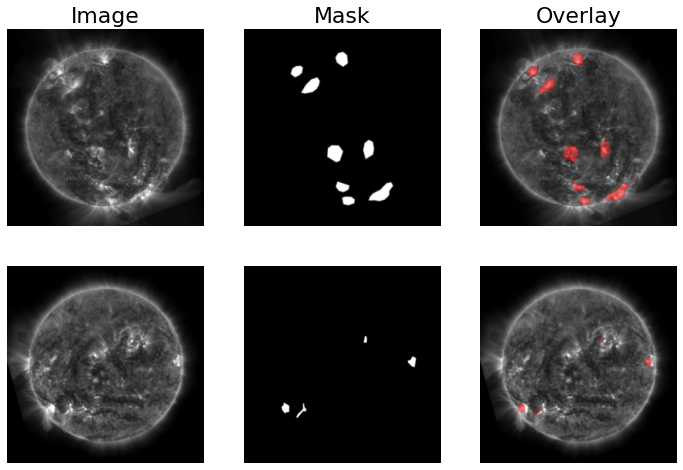

In [9]:
# Define augmentations for Train set
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=.5),
    albumentations.VerticalFlip(p=.5),
    albumentations.Rotate((-45, 45), p=.5, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomGamma((100, 150), p=.5),
    albumentations.RandomBrightnessContrast((.0, .2), (.0, .4), p=.5)
])

# Generator for images
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED)
img_gen = img_data_gen.flow(x_train, batch_size=BATCH_SIZE, shuffle=True)

# Generator for masks
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED, label_augment_mode='mask')
mask_gen = mask_data_gen.flow(y_train, batch_size=BATCH_SIZE, shuffle=True)

# Train set with augmented data
train_gen = zip(img_gen, mask_gen)

# Plot samples of augmented imgs
x_sample, y_sample = next(train_gen)
plot_imgs(imgs=x_sample, masks=y_sample, n_imgs=2).show()

* Chcek if shapes of input is suitable for model training

In [10]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (256, 256, 1)
Train shape: (5846, 256, 256, 1)  Val shape: (650, 256, 256, 1)


# 3. Deep learning approach

* The SCSS-net model architecture is defined in **../src/model_scss_net.py**. Load the model with the parameters that were found to be optimal for Coronal Holes. This is transfer learning (develop model approach).

In [11]:
# Create model with specific parameteres
model = scss_net(
    input_shape,
    filters=32,  
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE  

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice]  
)


* Train the model - uncomment the following code and train the model just if the satisfactory computational power is available (training took approx. 6 hours by using CPU Intel i58300H, RAM 32GB, GPU NVIDIA GeForce GTX1060 Max-Q 6GB)

In [12]:
# # Train model
# history = model.fit(
#     train_gen,
#     steps_per_epoch=STEPS,
#     epochs=EPOCHS,
#     validation_data=(x_val, y_val),
#     callbacks=[callback_checkpoint],
#     verbose=2
# )

# # Plot training history and predicted imgs
# plot_metrics(history).show()
# plot_imgs(imgs=x_val, masks=y_val, predictions=y_pred, n_imgs=2).show()

In [13]:
# if the previous cell with the training of the model was skipped, download already trained model (~100 MB)
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/RDxGTBjQ#7jrveEapvxTKod6gtcPpbjPNtLvvoNLMM2D7F29Udy4')
except PermissionError:
    pass
print("DONE")

DONE


* Load the trained model

In [14]:
model.load_weights(model_filename)

# 4. Results od SCSS-net

## 4.1 Results on validation set

* Predict new masks for validation set

In [15]:
y_pred = model.predict(x_val)  

* Plot Image sequence: 
 - input image for SCSS-Net 
 - ground truth (i.e. annotation mask)
 - output of SCSS-Net (i.e. predicted segmentation mask)
 - predicted segmentation mask as an overlay on the input image

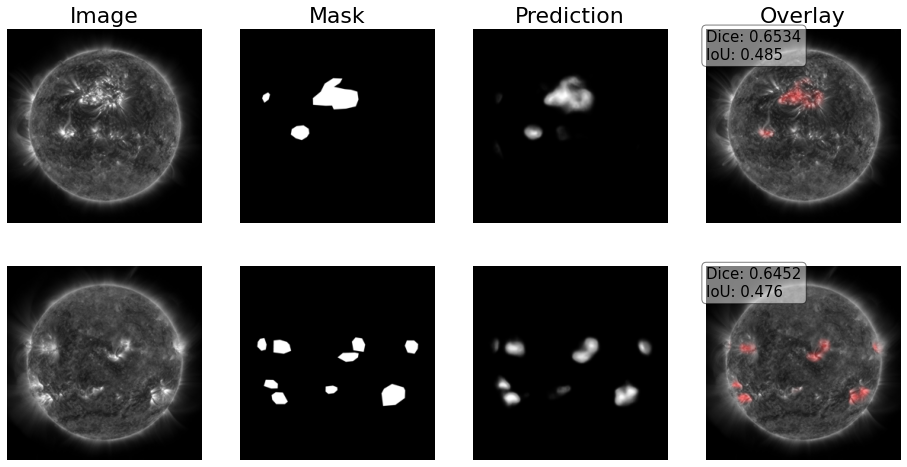

In [16]:
plot_imgs(imgs=x_val, masks=y_val, predictions=y_pred, n_imgs=2).show()

* Calculate averaged metrics (Dice and IoU) over the validation set without and with applied threshold

In [17]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Threshold predicted values

dice = np.round(dice_np(y_val, y_pred), 4)
iou_val = np.round(iou_np(y_val, y_pred), 4)

dice_tresh = np.round(dice_np(y_val, y_pred_bin), 4)
iou_val_tresh = np.round(iou_np(y_val, y_pred_bin), 4)

print(f"Validation:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_val} IoU_tresh: {iou_val_tresh}\n")

Validation:
Dice: 0.4516 Dice_tresh: 0.5175
 IoU: 0.2917 IoU_tresh: 0.3491



## 4.2 Results on test set

* Prepare test set


In [18]:
imgs_test = glob.glob("./data/171_test/imgs/*.png")
masks_test = glob.glob("./data/171_test/masks(spoca)/*.png")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

# Load data and convert imgs to np.array
imgs_list = []
masks_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_list, dtype=np.float32)/255
y_test = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

Imgs number = 360
Masks number = 360


* Predict new masks for test set and plot image sequence:

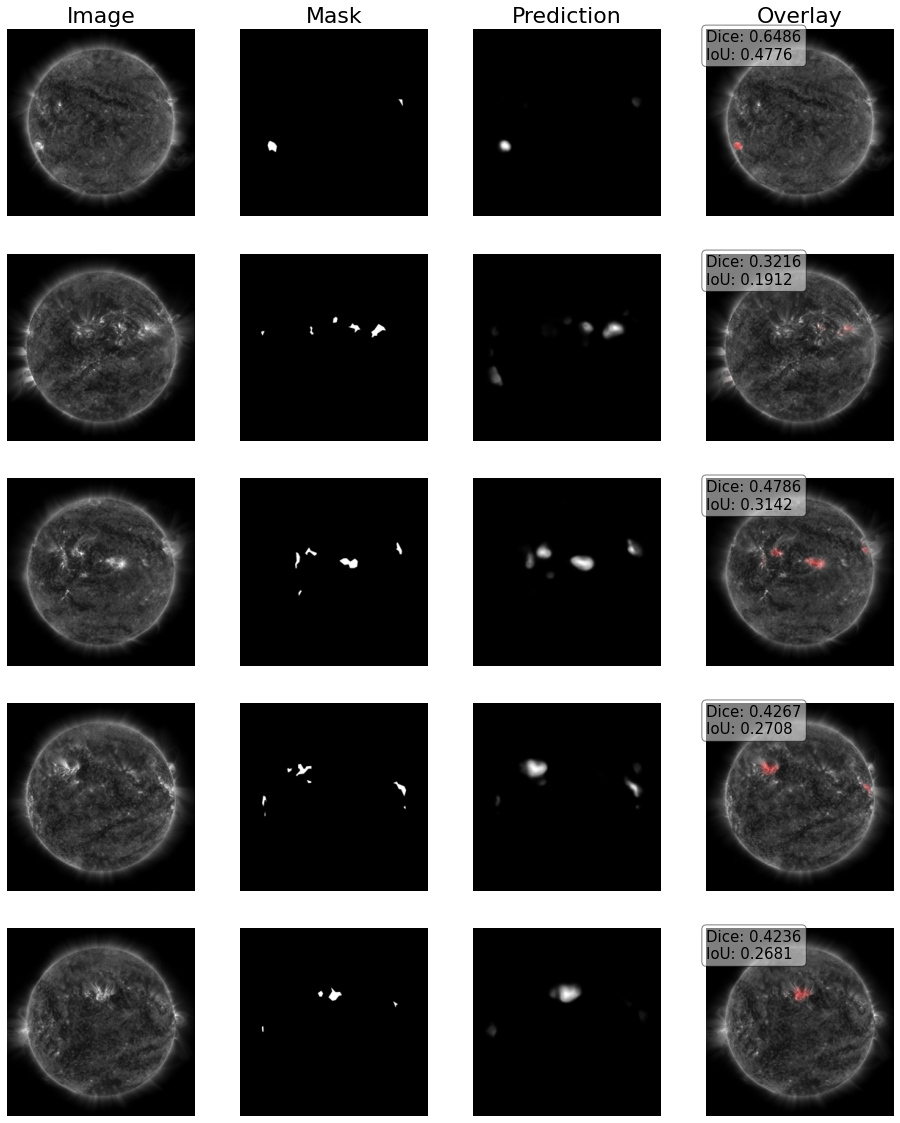

In [19]:
y_pred = model.predict(x_test)
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=5).show()

* Calculate averaged metrics over the test set without and with applied threshold

In [20]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Binarize predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.4456 Dice_tresh: 0.64
 IoU: 0.2867 IoU_tresh: 0.4706



In general, the performance of the SCSS-Net is satisfactory but not so good as for the coronal holes. The reason is imperfection of annotations needed for re-training of the model. Even though, it is presented that SCSS-Net created for one type of coronal structures (coronal holes) can be easily re-trained for segmentation of another type of coronal structures (active regions). 

* Vizualization of results: Stability of Dice score over test set

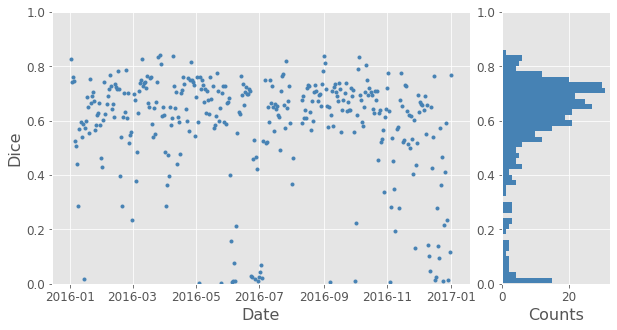

The Dice score is higher than 0.6 for 62.5% of images in test set.


In [21]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dates = [img.split("/")[-1].replace("__SDO_AIA_AIA_171", "").replace(".png", "") for img in masks_test]
dates = [datetime.strptime(date, '%Y_%m_%d__%H_%M_%S_%f') for date in dates]
dice = [dice_np(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred_bin)]

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(20, 20)
ax_scatter = fig.add_subplot(gs[0:20, 0:15])
ax_hist_x = fig.add_subplot(gs[0:20, 16:20])
ax_scatter.set_xlabel("Date", fontsize=16)
ax_scatter.set_ylabel("Dice", fontsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=12)
ax_hist_x.set_xlabel("Counts", fontsize=16)
ax_hist_x.tick_params(axis='both', which='major', labelsize=12)
ax_scatter.set_ylim([0, 1])
ax_hist_x.set_ylim([0, 1])
ax_scatter.plot(dates, dice,'.', label=f'Averaged Dice for SCSS-Net = {dice_tresh}', color='steelblue')
ax_hist_x.hist(dice, orientation = 'horizontal', bins=100, color='steelblue')
plt.show()

print(f'The Dice score is higher than 0.6 for {round(len([i for i in dice if i > 0.6])/len(dice)*100,2)}% \
of images in test set.')

* Vizualization of results: Segmented AR area over test set

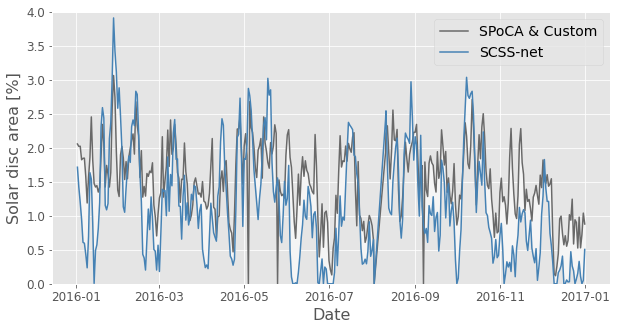

In [22]:
limb_total = 33633
segmented_area = [(((1 * (mask > 0)).sum() * 100)/limb_total) for mask in y_test]
predicted_area = [(((1 * (mask > 0)).sum() * 100)/limb_total) for mask in y_pred_bin]
dates_sorted, segmented_area_sorted = zip(*sorted(zip(dates, segmented_area)))
dates_sorted, predicted_area_sorted = zip(*sorted(zip(dates, predicted_area)))

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Solar disc area [%]", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0, 4])
plt.plot(dates_sorted, segmented_area_sorted, label='SPoCA & Custom', color='dimgray')
plt.plot(dates_sorted, predicted_area_sorted, label='SCSS-net', color='steelblue')
plt.fill_between(dates_sorted, segmented_area_sorted, predicted_area_sorted, color='whitesmoke')
plt.legend(loc='upper right', fontsize=14)
plt.show()